In [14]:
import netCDF4 as nc
import numpy as np
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
import torchvision.transforms as transforms
from torchvision.utils import save_image, make_grid

In [3]:
h1 = nc.Dataset('S5P_OFFL_L1C_SIFTPC_20240206T123417_20240206T123957_32732_93_000001_20241120T170117.nc')
africa = h1.groups['africa']

In [6]:
#Identify scanline in groundpixel 224 with clouds
scanline = africa.variables['scanline']
groundpixel = africa.variables['ground_pixel']
scanline_nocloud = []
for n in range(406):
    if africa.variables['CloudFraction'][0,n,224]<0.5:
        scanline_nocloud.append(n)

370

In [7]:
#Fixing albedo 
import numpy.polynomial.polynomial as po
def indexate(wl, ranges):
    if isinstance(ranges[0], (int, float)):  # Single range
        start, end = ranges
        return np.where((wl >= start) & (wl <= end))[0]
    else:  # Multiple ranges
        indices = np.concatenate([np.where((wl >= start) & (wl <= end))[0] for start, end in ranges])
        return np.sort(indices)
#len(africa.variables['Reflectance_wl'][0, 0 , 224, :]) ##this is how you check when reflectance wavelength starts and ends and its length
wl = np.linspace(700.06,785.16,692) #Define the wavelenth in terms of the spectral channels 
retrievalWindow = (734, 758) # retrieval wavelength window [nm]
windowsOfNoAbsorption = ((712, 713), (748, 757), (775, 785)) # windows for no atmospheric absorption [nm]
sb_order = 2 # order of polynomial fit of surface reflectivity (barren)
ind    = indexate(wl, retrievalWindow)
ind_na = indexate(wl, windowsOfNoAbsorption)
ref_na = africa.variables["Reflectance"][0, scanline_nocloud, 224, ind_na].data.tolist()

#for each scanline model the albedo with the noabsobtion window of reflectance
surf_albedo = np.zeros((370, 195))
for i in range(370):
    poly_sa = po.polyfit (wl[ind_na], ref_na[i], sb_order)
    surf_alb = po.polyval (wl[ind], poly_sa) 
    surf_albedo[i, :] = surf_alb

In [25]:
#Computing tau
mu = np.cos(np.radians(africa.variables["VZA"][0,scanline_nocloud,224]))
mu_0 = np.cos(np.radians(africa.variables["SZA"][0,scanline_nocloud,224]))
mu_matrix = np.cos(np.tile(mu[:, np.newaxis], 195))
mu_0_matrix = np.cos(np.tile(mu_0[:, np.newaxis], 195))
reflectance_matrix = africa.variables['Reflectance'][0, scanline_nocloud, 224, 276:471].data

tau = -np.log(reflectance_matrix/surf_albedo)/ (np.reciprocal(mu_matrix)+ np.reciprocal(mu_0_matrix))
surf_albedo.shape, tau.shape

((370, 195), (370, 195))

In [42]:
data_tensor = torch.tensor(tau, dtype=torch.float32)

# Wrap it in a dataset
dataset = TensorDataset(data_tensor)

# Split into training (80%) and test (20%) sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# Create dataloaders
batch_size = 50
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

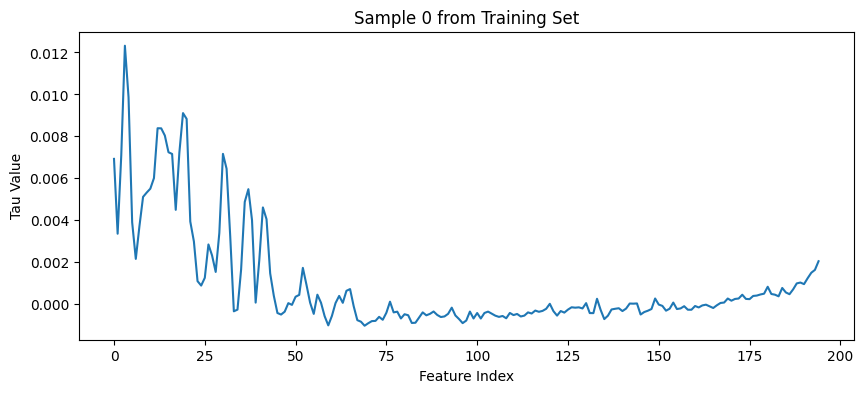

In [43]:
##VISUALISE SOME TRANING DATA 
batch = next(iter(train_loader))
tau_batch = batch[0]  # Extract tau_tensor from the batch

# Select a sample to plot (first one in the batch)
sample_index = 0
tau_sample = tau_batch[sample_index].squeeze().numpy()  # Shape (406,)

# Plot
plt.figure(figsize=(10, 4))
plt.plot(tau_sample)
plt.xlabel("Feature Index")
plt.ylabel("Tau Value")
plt.title(f"Sample {sample_index} from Training Set")
plt.show()


In [49]:
import torch.nn as nn
import torch.optim as optim

class VAE(nn.Module):
    def __init__(self, input_dim=195, latent_dim=10):
        super(VAE, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU()
        )
        self.fc_mu = nn.Linear(128, latent_dim)  # Mean
        self.fc_logvar = nn.Linear(128, latent_dim)  # Log variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)  # Output must match input shape
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std  # Sample from the latent space

    def forward(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        return x_hat, mu, logvar

# Define model
latent_dim = 10  # Size of latent space
model = VAE(input_dim=195, latent_dim=latent_dim).to(device)

# Loss function (Reconstruction loss + KL divergence)
def loss_function(x, x_hat, mu, logvar):
    recon_loss = nn.MSELoss()(x_hat, x)  # Reconstruction error
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  # KL divergence
    return recon_loss + kl_div

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
epochs = 50
for epoch in range(epochs):
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 0.6866255402565002
Epoch 2, Loss: 0.22484208643436432
Epoch 3, Loss: 0.04606550931930542
Epoch 4, Loss: 0.0391184464097023
Epoch 5, Loss: 0.039064567536115646
Epoch 6, Loss: 0.018820282071828842
Epoch 7, Loss: 0.011841370724141598
Epoch 8, Loss: 0.009206287562847137
Epoch 9, Loss: 0.007238427177071571
Epoch 10, Loss: 0.005205082707107067
Epoch 11, Loss: 0.004983660764992237
Epoch 12, Loss: 0.004191379062831402
Epoch 13, Loss: 0.003780779428780079
Epoch 14, Loss: 0.003913301508873701
Epoch 15, Loss: 0.0034468763042241335
Epoch 16, Loss: 0.0028637568466365337
Epoch 17, Loss: 0.003156898310407996
Epoch 18, Loss: 0.0027772558387368917
Epoch 19, Loss: 0.0026494283229112625
Epoch 20, Loss: 0.0025698409881442785
Epoch 21, Loss: 0.0024468526244163513
Epoch 22, Loss: 0.0021793947089463472
Epoch 23, Loss: 0.001941006281413138
Epoch 24, Loss: 0.0019204247510060668
Epoch 25, Loss: 0.0017800211207941175
Epoch 26, Loss: 0.0016418590676039457
Epoch 27, Loss: 0.001624106545932591
Epoch 

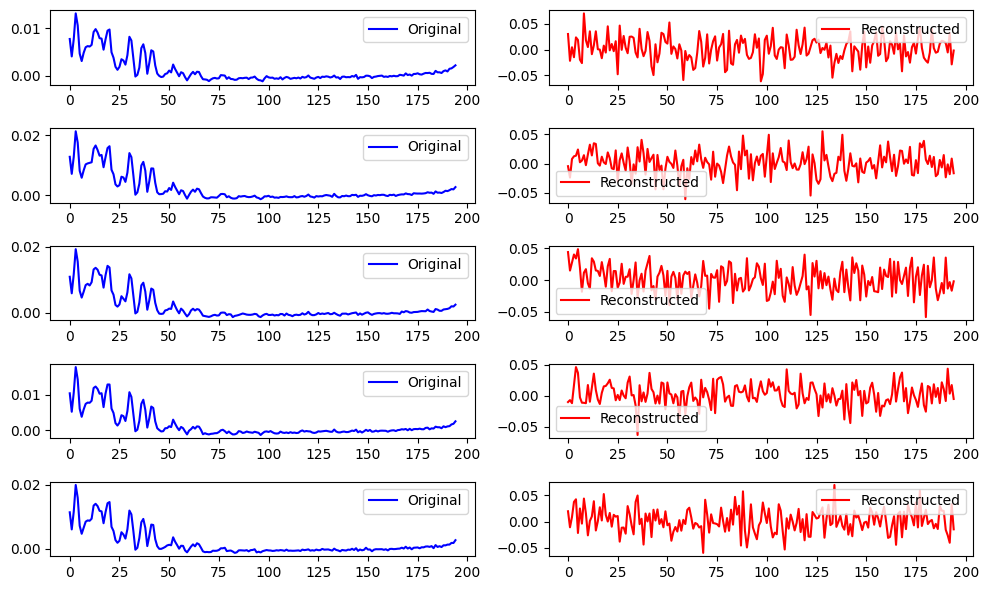

In [50]:
# Get a batch from the test set
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    for batch in test_loader:
        x = batch[0].to(device)  # Get test functions
        x_hat, _, _ = model(x)  # Reconstruct functions
        break  # Take only one batch

# Convert tensors to numpy for plotting
x = x.cpu().numpy()
x_hat = x_hat.cpu().numpy()

# Plot a few original and reconstructed functions
num_samples = 5  # Number of functions to plot
plt.figure(figsize=(10, 6))
for i in range(num_samples):
    plt.subplot(num_samples, 2, 2 * i + 1)
    plt.plot(x[i], label="Original", color="blue")
    plt.legend()
    plt.subplot(num_samples, 2, 2 * i + 2)
    plt.plot(x_hat[i], label="Reconstructed", color="red")
    plt.legend()
plt.tight_layout()
plt.show()

In [44]:
class VAE(nn.Module):

    def __init__(self, input_dim=370, hidden_dim=250, latent_dim=195, device=device):
        super(VAE, self).__init__()

        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, latent_dim),
            nn.LeakyReLU(0.2)
            )
        
        # latent mean and variance 
        self.mean_layer = nn.Linear(latent_dim, 2)
        self.logvar_layer = nn.Linear(latent_dim, 2)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, latent_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(latent_dim, hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
            )
     
    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = self.mean_layer(x), self.logvar_layer(x)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(device)      
        z = mean + var*epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, log_var

In [45]:
model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [46]:
#Maybe change this for PCA
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

In [48]:
batch_size = 32
# Training loop
epochs = 50
for epoch in range(epochs):
    for batch in train_loader:
        x = batch[0].to(device)
        optimizer.zero_grad()
        x_hat, mu, logvar = model(x)
        loss = loss_function(x, x_hat, mu, logvar)
        loss.backward()
        optimizer.step()
    
    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


RuntimeError: mat1 and mat2 shapes cannot be multiplied (50x195 and 370x250)